In [2]:
from matplotlib import pyplot as plt
import numpy as np

import prizmatoid as pzt
import metadatabase as mdb
try:
    reload(pzt)
    reload(mdb)
except:
    from importlib import reload
    reload(pzt)
    reload(mdb)

## Metadatabase

Here we demonstrate how to simultaneously load multiple data chunks using the new PRIZM metadatabase and its utility functions. We begin by setting the directories where the data and data patches are located:

In [3]:
mdb.data_directory = '/Volumes/PRIZM_DISK1'
mdb.patches_directory = '/Users/Fernando/Documents/Code/Modules/PRIZM/Zago/patches_data'

Next, specify the time intervals and PRIZM components of interest.

In [4]:
ctime_intervals = [(1524600000, 1524700000), (1524700000, 1524800000)]
components=['70MHz', 'switch']

In [5]:
prizm_data = mdb.load_multiple_data(ctime_intervals, components, verbose=False)

No files named `open.scio` could be found and/or read.
No files named `open.scio` could be found and/or read.
No files named `open.scio` could be found and/or read.
No files named `open.scio` could be found and/or read.
No files named `open.scio` could be found and/or read.
No files named `open.scio` could be found and/or read.
No files named `open.scio` could be found and/or read.
No files named `open.scio` could be found and/or read.
No files named `open.scio` could be found and/or read.
No files named `open.scio` could be found and/or read.
No files named `open.scio` could be found and/or read.
No files named `open.scio` could be found and/or read.
No files named `open.scio` could be found and/or read.
No files named `open.scio` could be found and/or read.
No files named `open.scio` could be found and/or read.
No files named `open.scio` could be found and/or read.
No files named `open.scio` could be found and/or read.
No files named `open.scio` could be found and/or read.
No files n

Notice also that the above `load_multiple_data` function automatically applies the necessary patches to the data of interest. This includes trimming glitchy portions of the data, correcting timestamp issues, and ignoring corructed data.

The `prizm_data` dictionary is backwards compatible with all `prizmatoid` functions, so all data operations from before should work as intended. Below we go through some of the same manipulations demonstrated in previous Jupyter notebooks:

In [6]:
prizm_data['switch']

{'antenna.scio': array([[1.00000000e+00, 1.52460136e+09],
        [0.00000000e+00, 1.52460196e+09],
        [1.00000000e+00, 1.52460220e+09],
        [0.00000000e+00, 1.52460280e+09],
        [1.00000000e+00, 1.52460304e+09],
        [0.00000000e+00, 1.52460364e+09],
        [1.00000000e+00, 1.52460389e+09],
        [0.00000000e+00, 1.52460449e+09],
        [1.00000000e+00, 1.52460473e+09],
        [0.00000000e+00, 1.52460533e+09],
        [1.00000000e+00, 1.52460557e+09],
        [0.00000000e+00, 1.52460617e+09],
        [1.00000000e+00, 1.52460642e+09],
        [0.00000000e+00, 1.52460702e+09],
        [1.00000000e+00, 1.52460726e+09],
        [0.00000000e+00, 1.52460786e+09],
        [1.00000000e+00, 1.52460810e+09],
        [0.00000000e+00, 1.52460870e+09],
        [1.00000000e+00, 1.52460895e+09],
        [0.00000000e+00, 1.52460955e+09],
        [1.00000000e+00, 1.52460979e+09],
        [0.00000000e+00, 1.52461039e+09],
        [1.00000000e+00, 1.52461063e+09],
        [0.0000000

In [6]:
prizm_data['70MHz']

{'pol0.scio': array([[81166337078, 20050289736,  1744080944, ...,    19734686,
            28368972,    27966302],
        [84446654462, 20081538674,  1736482558, ...,    19207182,
            28695590,    28152208],
        [82858548466, 20155153220,  1739885504, ...,    20191608,
            28203938,    28036040],
        ...,
        [74164981554, 34874801128,  1562308766, ...,    16517130,
            15859762,    15564564],
        [70967473718, 34682218934,  1578449638, ...,    16363966,
            15829106,    15386688],
        [69707910798, 34814146160,  1567398958, ...,    16466842,
            16032622,    15570492]]),
 'pol1.scio': array([[46944856638, 21001336058,  1893922478, ...,     8302398,
             8478198,     7533778],
        [51855978922, 21020409584,  1882993376, ...,     8316434,
             8459056,     7528512],
        [54326426816, 21090044832,  1886563174, ...,     8289470,
             8385076,     7501660],
        ...,
        [28001883718, 378298

In [7]:
prizm_data['70MHz']['pol0.scio']

array([[101535667468,   6154705454,    522842428, ...,     11848902,
            25563786,     26750196],
       [ 98440767954,   6155971684,    522900242, ...,     11907240,
            26202972,     27253902],
       [ 97520590642,   6157059262,    523133064, ...,     12114368,
            26880908,     26902818],
       ...,
       [116558529052,   6634077278,    446698896, ...,     32473644,
            18533872,     26732110],
       [117385042836,   6632741314,    446988590, ...,     32689270,
            19688876,     26956510],
       [114088102860,   6632949460,    446980942, ...,     34155444,
            20068870,     27623082]])

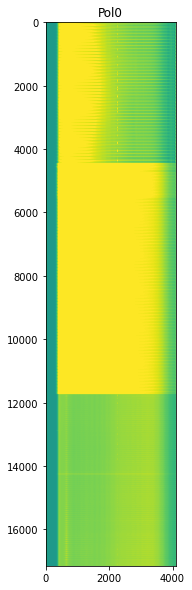

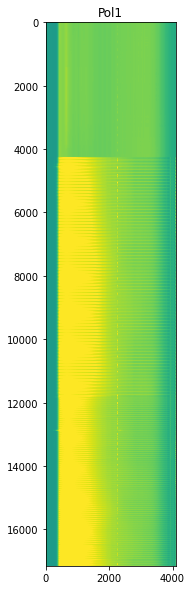

In [7]:
# Plots the polarization channel 'Pol0' on a logarithmic color scale.
plt.figure(1, figsize=(10, 10))
plt.title('Pol0')
plt.imshow(np.log10(prizm_data['70MHz']['pol0.scio']), vmin=4.5, vmax=8.5)

# Plots the polarization channel 'Pol1' on a logarithmic color scale.
plt.figure(2, figsize=(10, 10))
plt.title('Pol1')
plt.imshow(np.log10(prizm_data['70MHz']['pol1.scio']), vmin=4.5, vmax=8.5)

Here we plot the `time_sys_start.raw` and `time_sys_stop.raw` entries of `prizm_data` dictionary

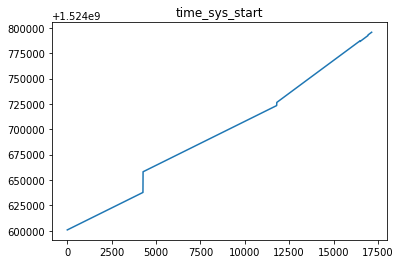

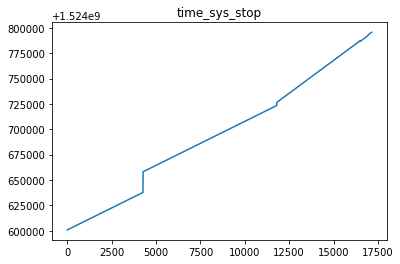

In [8]:
# Plots the timestamp 'time_sys_start.raw' data associated with 70MHz antenna.
plt.figure(1)
plt.title('time_sys_start')
plt.plot(prizm_data['70MHz']['time_sys_start.raw'])

# Plots the timestamp 'time_sys_stop.raw' data associated with 70MHz antenna.
plt.figure(2)
plt.title('time_sys_stop')
plt.plot(prizm_data['70MHz']['time_sys_stop.raw'])

The function `add_switch_flags` adds a new entry to `prizm_data` containing information which allows us to separate the data collected during different operation modes.

In [9]:
pzt.add_switch_flags(prizm_data, antennas=['70MHz'])

In [10]:
prizm_data['70MHz']['switch_flags']

{'antenna.scio': array([0, 0, 0, ..., 1, 1, 1]),
 'noise.scio': array([0, 0, 0, ..., 0, 0, 0]),
 'res100.scio': array([0, 0, 0, ..., 0, 0, 0]),
 'res50.scio': array([0, 0, 0, ..., 0, 0, 0]),
 'short.scio': array([0, 0, 0, ..., 0, 0, 0])}

Each of the `'switch_flags'` entries is a NumPy array containing 0's and 1's which can be used to select the parts of the data associated with each observing mode. The four observing modes are the following:

- `'antenna.scio'`: the mode in which the antenna is observing the sky.
- `'res100.scio'`: the mode in which the instrument records the load from an internal 100 Ohm resistor. 
- `'res50.scio'`: the mode in which the instrument records the load from an internal 50 Ohm resistor. 
- `'short.scio'`: the mode in which the instrument is shorted, and therefore records only internally generated signals.
- `'noise.scio'`: the mode in which the instrument records the signal from an internal noise source.

To create filters capable of selecting the data associated with each of these modes, use the following expressions which transform the `1` and `0` entries of each flag arrays into `True` and `False`, respectively. (Here we also use the `shrink_flag` function to crop the first and last samples of each flag field).

In [11]:
# Stores the different flags into NumPy arrays.
select_antenna = (pzt.shrink_flag(prizm_data['70MHz']['switch_flags']['antenna.scio'], (1,1)) == 1)
select_res100 = (pzt.shrink_flag(prizm_data['70MHz']['switch_flags']['res100.scio'], (1,1)) == 1)
select_res50 = (pzt.shrink_flag(prizm_data['70MHz']['switch_flags']['res50.scio'], (1,1)) == 1)
select_short = (pzt.shrink_flag(prizm_data['70MHz']['switch_flags']['short.scio'], (1,1)) == 1)
select_noise = (pzt.shrink_flag(prizm_data['70MHz']['switch_flags']['noise.scio'], (1,1)) == 1)

We can check that these flags make sense by plotting them together as follows.

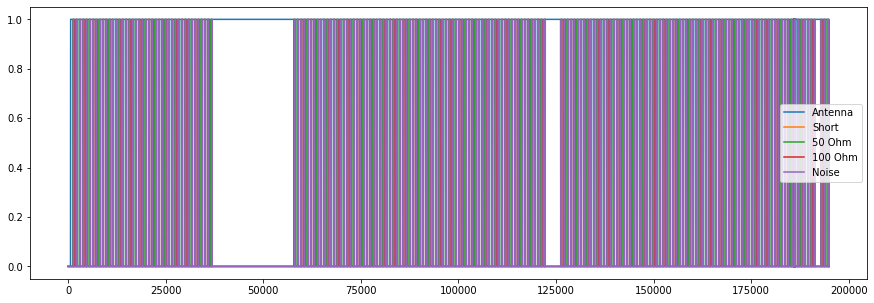

In [12]:
# Plots the different flags.
plt.figure(1, figsize=(15, 5))

# Uses the `prizm_data['70MHz']['time_sys_start.raw'][0]` as a time reference for the switch states.
data_time = prizm_data['70MHz']['time_sys_start.raw'] - prizm_data['70MHz']['time_sys_start.raw'][0]

# Show when each observing mode is active as a function of time.
plt.plot(data_time, select_antenna, label='Antenna')
plt.plot(data_time, select_short, label='Short')
plt.plot(data_time, select_res50, label='50 Ohm')
plt.plot(data_time, select_res100, label='100 Ohm')
plt.plot(data_time, select_noise, label='Noise')

# Legend and x-axis range.
plt.legend(loc='best')

Since the flags generated above are composed of entries which are either `True` or `False`, they can be used to slice the data and extract any observing mode of interest. Below we perform this selection.

In [13]:
# Selects the data from the 'pol0.scio' channel associated with the different observing modes.
antenna_data_pol0 = prizm_data['70MHz']['pol0.scio'][select_antenna]
res100_data_pol0 = prizm_data['70MHz']['pol0.scio'][select_res100]
res50_data_pol0 = prizm_data['70MHz']['pol0.scio'][select_res50]
short_data_pol0 = prizm_data['70MHz']['pol0.scio'][select_short]
noise_data_pol0 = prizm_data['70MHz']['pol0.scio'][select_noise]

# Selects the data from the 'pol1.scio' channel associated with the different observing modes.
antenna_data_pol1 = prizm_data['70MHz']['pol1.scio'][select_antenna]
res100_data_pol1 = prizm_data['70MHz']['pol1.scio'][select_res100]
res50_data_pol1 = prizm_data['70MHz']['pol1.scio'][select_res50]
short_data_pol1 = prizm_data['70MHz']['pol1.scio'][select_short]
noise_data_pol1 = prizm_data['70MHz']['pol1.scio'][select_noise]

The data associated with the antenna observations alone can now be plotted independently.

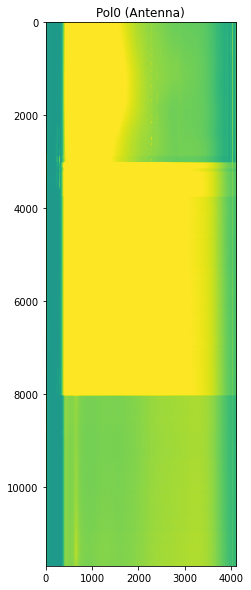

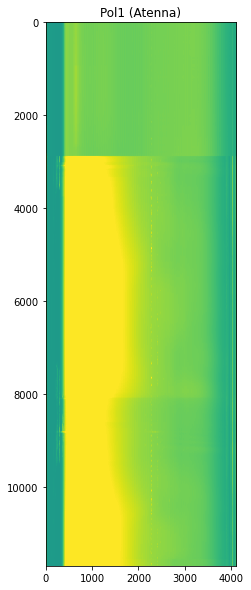

In [14]:
# Plots the 'antenna.scio' mode for the polarization channel 'Pol0' on a logarithmic color scale.
plt.figure(1, figsize=(10, 10))
plt.title('Pol0 (Antenna)')
plt.imshow(np.log10(antenna_data_pol0), vmin=4.5, vmax=8.5)

# Plots the 'antenna.scio' mode for the polarization channel 'Pol1' on a logarithmic color scale.
plt.figure(2, figsize=(10, 10))
plt.title('Pol1 (Atenna)')
plt.imshow(np.log10(antenna_data_pol1), vmin=4.5, vmax=8.5)

Below we show the the analogous plots for the `short.scio`, `res50.scio`, and `res100.scio` observing modes associated with the `pol0.scio` channel.

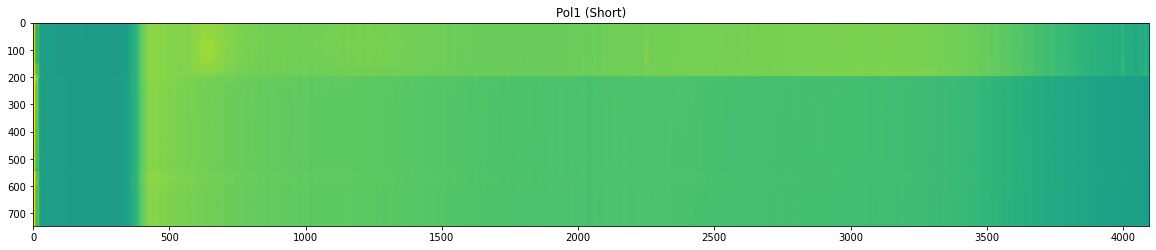

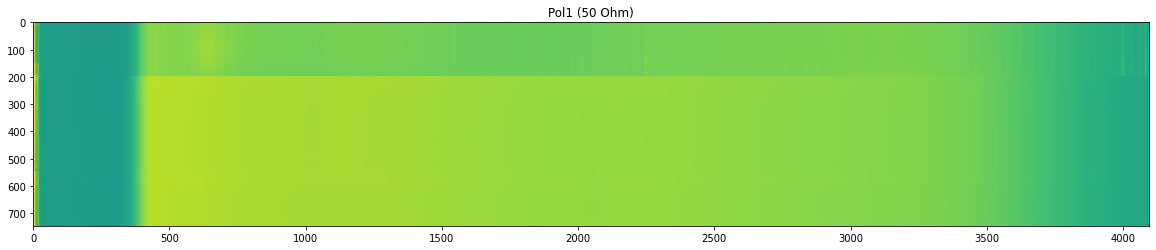

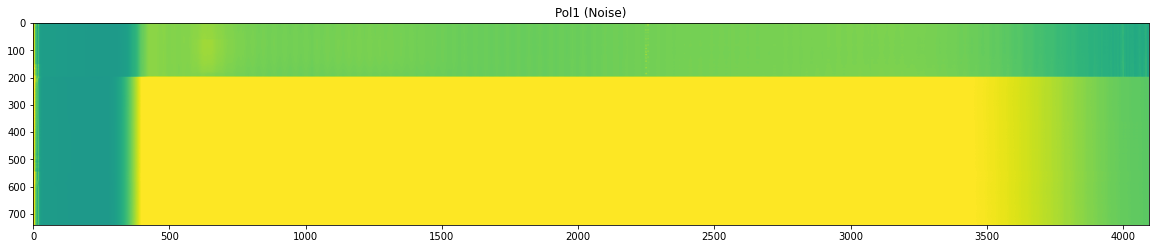

In [17]:
# Plots the 'short.scio' mode for the polarization channel 'Pol1' on a logarithmic color scale.
plt.figure(1, figsize=(20, 10))
plt.title('Pol1 (Short)')
plt.imshow(np.log10(short_data_pol1), vmin=4.5, vmax=8.5)

# Plots the 'res50.scio' mode for the polarization channel 'Pol1' on a logarithmic color scale.
plt.figure(2, figsize=(20, 10))
plt.title('Pol1 (50 Ohm)')
plt.imshow(np.log10(res50_data_pol1), vmin=4.5, vmax=8.5)

# Plots the 'res100.scio' mode for the polarization channel 'Pol1' on a logarithmic color scale.
plt.figure(3, figsize=(20, 10))
plt.title('Pol1 (100 Ohm)')
plt.imshow(np.log10(res100_data_pol1), vmin=4.5, vmax=8.5)

# Plots the 'noise.scio' mode for the polarization channel 'Pol1' on a logarithmic color scale.
plt.figure(3, figsize=(20, 10))
plt.title('Pol1 (Noise)')
plt.imshow(np.log10(noise_data_pol1), vmin=4.5, vmax=8.5)